# Dano's pyRiemann  notebook

In this notebook, I will try and use pyRiemann to perform feature selection and test what traditional ML algorithms would be useful to predict cognitive performance from EEG data in Neurodoro

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as sk
from os import walk
from os import listdir
from os.path import isfile, join
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.neighbors import KNeighborsRegressor
from tpot import TPOTRegressor
from math import sqrt
import pyriemann
from mne import create_info, concatenate_raws
from mne.io import RawArray
from mne.channels import read_montage
from glob import glob
from pyriemann.utils.viz import plt, plot_confusion_matrix, plot_embedding
from pyriemann.estimation import Covariances, HankelCovariances
from pyriemann.tangentspace import TangentSpace
from pyriemann.clustering import Potato

Notes:
- try alpha and beta common spatial pattern technique (supervised covariance feature extraction)
- Spoc source power of comodulation better for regression (doesn't use Riemannian space)

1. Concat all raw datasets together
2. Use Knearest Neighbors in pipeline

In [114]:
# Data has been collected, let's import it

data = pd.read_csv("../muse-data/DanoMondayRawEEG0.csv", header=0, index_col=False)

In [115]:
data = data[data.Performance != 0]

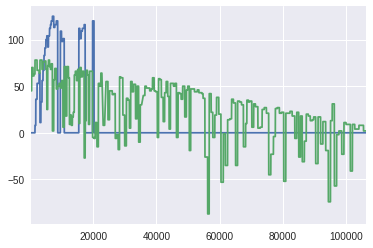

In [116]:
%matplotlib inline
data.Difficulty.plot()
data.Performance.plot()

In [117]:
sfreq = 256

# name of each channels 
ch_names = ['Diff', 'TP9', 'FP1', 'FP2', 'TP10']

# type of each channels
ch_types = ['stim'] + ['eeg'] * 4
montage = read_montage('standard_1005')

# get data and exclude Aux channel
data = data.values[:,-5:].T
data

# convert in Volts (from uVolts)
#data[:-1] *= 1e-6

# create mne objects
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sfreq, montage=montage)
raw = (RawArray(data=data, info=info))

Creating RawArray with float64 data, n_channels=5, n_times=104433
    Range : 0 ... 104432 =      0.000 ...   407.938 secs
Ready.


tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
Effective window size : 8.000 (s)


<ipython-input-118-39b392d59ea0>:3: DeprecationWarning: tmax defaults to 60. in 0.14 but will change to np.inf in 0.15. Set it explicitly to avoid this warning
  raw.plot_psd(picks=[1]);
/home/dano/anaconda3/lib/python3.6/site-packages/mne/viz/raw.py:614: DeprecationWarning: In version 0.15 average will default to False and spatial_colors will default to True.
  'spatial_colors will default to True.', DeprecationWarning)


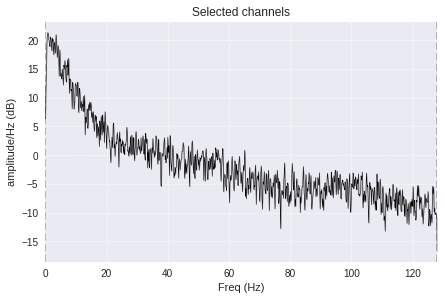

In [118]:
## Plot the PSD of the EEG data just to make sure it looks alright

raw.plot_psd(picks=[1]);


In [119]:
raw.filter(2, 50, method='iir')

Setting up band-pass filter from 2 - 50 Hz


<RawArray  |  None, n_channels x n_times : 5 x 104433 (407.9 sec), ~4.0 MB, data loaded>

## Epochs

In [120]:
from mne import make_fixed_length_events, Epochs

# Make an events array with epoch times every .5 seconds
event = make_fixed_length_events(raw, 1, duration=0.5)

# Make an epochs array object from the raw dataset with events array event, length of 2 seconds
epochs = Epochs(raw, event, tmin=0, tmax=4, preload=True)

epochs

815 matching events found
0 projection items activated
Loading data for 815 events and 1025 original time points ...
7 bad epochs dropped


<Epochs  |  n_events : 808 (all good), tmin : 0.0 (s), tmax : 4.0 (s), baseline : (None, 0), ~31.6 MB, data loaded>

In [121]:
X = epochs.copy().pick_types(eeg=True).get_data()

y = epochs.copy().pick_types(eeg=False, stim=True).get_data().mean(axis=2)
print(X.shape, y.shape)

(808, 4, 1025) (808, 1)


In [100]:
# Let's transform our data into a covariance matrix and a tangentspace
covs = Covariances().fit_transform(X)
tans = TangentSpace().fit_transform(covs)
potato = Potato().fit_transform(covs)

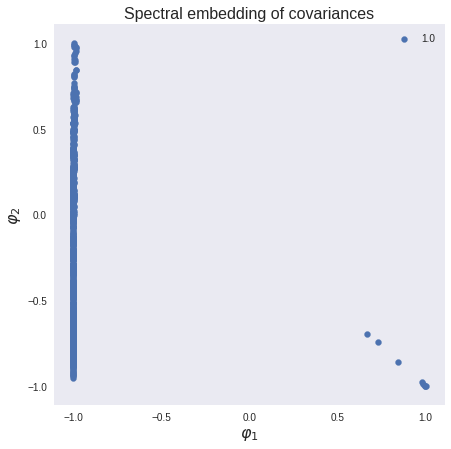

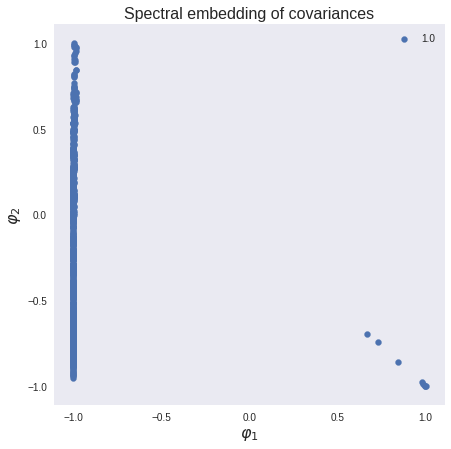

In [101]:
# Now that we have our data setup for sklearn in X and y, let's visualize it

plot_embedding(covs)

In [124]:
clf = make_pipeline(Covariances(), TangentSpace(), KNeighborsRegressor(n_neighbors=52, p=1, weights="distance"))

clf.fit(X, y)

Pipeline(steps=[('covariances', Covariances(estimator='scm')), ('tangentspace', TangentSpace(metric='riemann', tsupdate=False)), ('kneighborsregressor', KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=52, p=1,
          weights='distance'))])

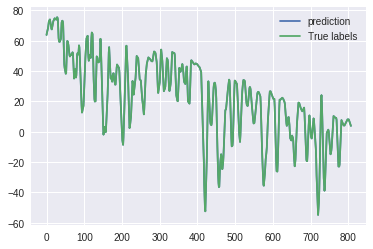

In [125]:
pr = clf.predict(X)
plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])

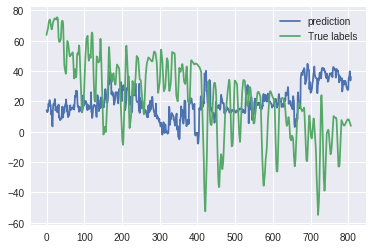

In [126]:
from sklearn.model_selection import cross_val_score, cross_val_predict

pr = cross_val_predict(clf, X, y, cv=6)

plt.plot(pr)
plt.plot(y)
plt.legend(['prediction', 'True labels'])


In [127]:
print(sqrt(sk.metrics.mean_squared_error(y,pr)))

32.32168503358566


# Nice!

In [279]:
pipeline_optimizer.export('tpot_exported_pipeline_riemann2.py')